# Emulate COSMOS observations with MassiveNuS

In this notebook, we create a toy dataset using MassiveNuS and the mask from the COSMOS survey.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.io import fits
import tensorflow as tf
import tensorflow_datasets as tfds
from jax_lensing.spectral import measure_power_spectrum
from jax_lensing.datasets.massivenu import MassiveNu
from jax_lensing.inversion import ks93, ks93inv
import jax.numpy as jnp

In [3]:
# Let's prepare some test data
def load_dataset():
  def pre_process(im):
    """ Pre-processing function preparing data for denoising task
    """
    # Cutout a portion of the map
    x = tf.expand_dims(im['map'],-1)
    return x
  ds = tfds.load('massive_nu', split='train[:-10%]', shuffle_files=False)
  ds = ds.map(pre_process)
  return iter(tfds.as_numpy(ds))

In [4]:
# Instantiate dataset and sample map
dset = load_dataset()
ref_map = next(dset)
ref_map = next(dset)
ref_map = next(dset)
ref_map = next(dset)
ref_map = next(dset)
# Load mask from COSMOS
mask = fits.getdata('../data/cosmos_mask_0.4arcmin.fits').astype('float32')

In [5]:
# This is our input map
imshow(ref_map)

In [6]:
# We turn it into shear
e1,e2 = ks93inv(ref_map[...,0], jnp.zeros_like(ref_map[...,0]))
# And we extract a patch that put the big cluster right at the edge
k = ref_map[256-160:256+160,210-160:210+160,0]
e1 = e1[256-160:256+160,210-160:210+160]
e2 = e2[256-160:256+160,210-160:210+160]

(-0.5, 319.5, 319.5, -0.5)

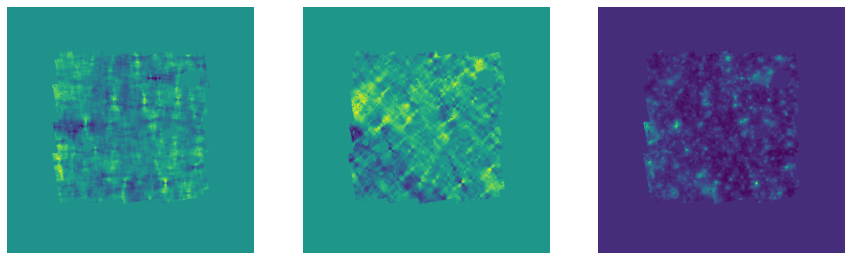

In [8]:
figure(figsize=[15,5])
subplot(131)
imshow(e1*mask)
axis('off')
subplot(132)
imshow(e2*mask)
axis('off')
subplot(133)
imshow(k*mask)
axis('off')

In [153]:
# We can save for testing this map with added noise
fits.writeto('../data/Mnu_cosmos_kappa.fits',k)
fits.writeto('../data/Mnu_cosmos_e.fits',
              np.stack([mask*(e1 + 0.15*randn(320,320)),
                        mask*(e2 + 0.15*randn(320,320))],axis=-1))

At this point, you can run the sampling code with:
```
python scripts/sample_maps.py --shear=data/Mnu_cosmos_e.fits --mask=data/cosmos_mask_0.4arcmin.fits --model_weights=/data/Scores/lensing/training_kl1_gaussian_01noise/model-final.pckl --output_file=test_samples.fits --batch_size=32 --gaussian_only=True --output_steps=1
```

In [17]:
# And load the results
s = fits.getdata('../test_samples.fits').astype('float32')

In [18]:
s.shape

(2, 32, 102400)

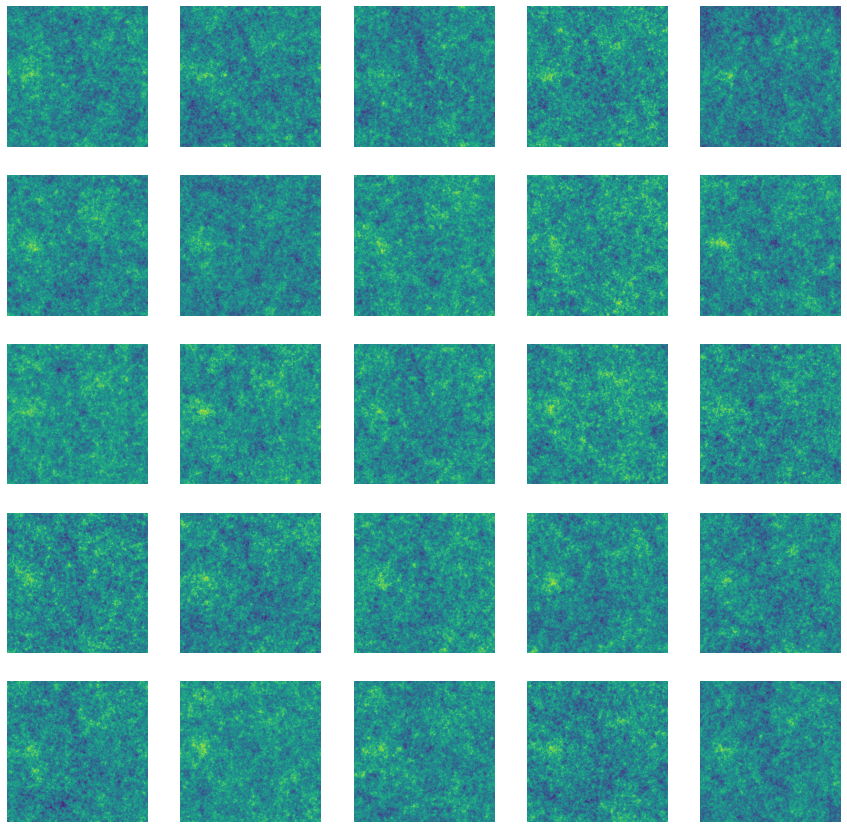

In [19]:
figure(figsize=[15,15])
for i in range(5):
    for j in range(5):
        subplot(5, 5, i*5+j+1)
        imshow(s[-1,i*5+j].reshape((320,320)))
        axis('off')

In [20]:
for i in range(32):
    loglog(measure_power_spectrum(s[-1,i].reshape((320,320))))

In [21]:
files = []
for i in range(32):
    plt.cla()
    im = s[-1, i].reshape((320, 320))[:,::-1]
    imshow(im,cmap='magma',vmin=s[-1].min(), vmax=s[-1].max(), 
           origin='lower')
    axis('off')
    fname = '_tmp%03d.png' % i
    plt.savefig(fname,dpi=300)
    files.append(fname)

## Bonus: application to real COSMOS data

Sampling is done with:
```
$ python scripts/sample_maps.py --shear=data/cosmos_e_0.4arcmin.fits --mask=data/cosmos_mask_0.4arcmin.fits --model_weights=/data/Scores/lensing/training_kl1_gaussian_01noise/model-final.pckl  --gaussian_only=True
```

In [13]:
# And load the results of the sampling
s = fits.getdata('../samples.fits').astype('float32')

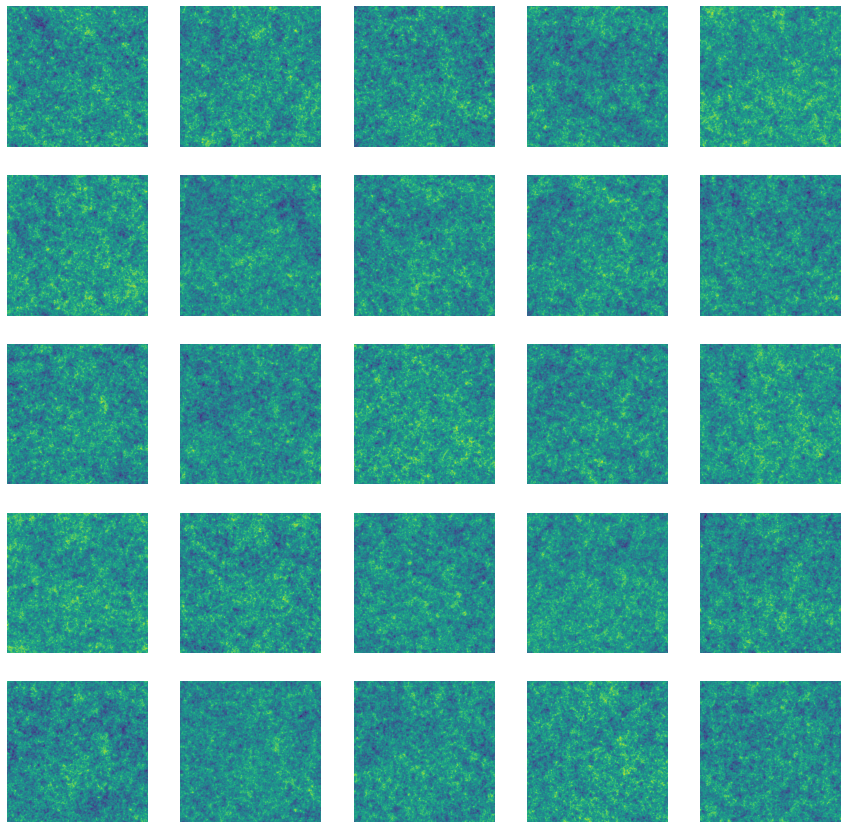

In [15]:
figure(figsize=[15,15])
for i in range(5):
    for j in range(5):
        subplot(5, 5, i*5+j+1)
        imshow(s[-1,i*5+j].reshape((320,320)))
        axis('off')

In [16]:
files = []
for i in range(32):
    plt.cla()
    im = s[-1, i].reshape((320, 320))[:,::-1]
    imshow(im,cmap='magma',vmin=s[-1].min(), vmax=s[-1].max(), 
           origin='lower')
    axis('off')
    fname = '_tmp%03d.png' % i
    plt.savefig(fname,dpi=300)
    files.append(fname)

In [ ]:
# And now you can make a movie with:
# ffmpeg -r 10 -f image2  -i _tmp%3d.png -vcodec libx264 -crf 15 movie_cosmos.mp4

Text(0.5, 1.0, 'std')

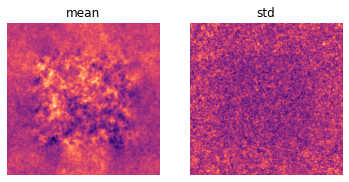

In [44]:
subplot(121)
imshow(s[-1].mean(axis=0).reshape((320,320))[:,::-1],cmap='magma',
       origin='lower')
axis('off')
title('mean')
subplot(122)
imshow(s[-1].std(axis=0).reshape((320,320))[:,::-1],cmap='magma',
       origin='lower')
axis('off')
title('std')

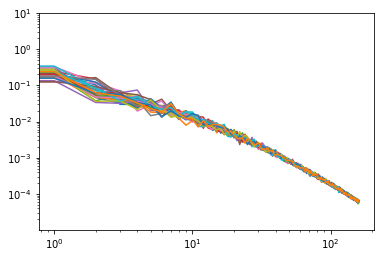

In [33]:
for i in range(32):
    loglog(measure_power_spectrum(s[-1,i].reshape((320,320))))

In [22]:
# We can also sample this time using the ML prior
s = fits.getdata('../samples_ml.fits').astype('float32')

In [23]:
s.shape

(2, 4, 102400)

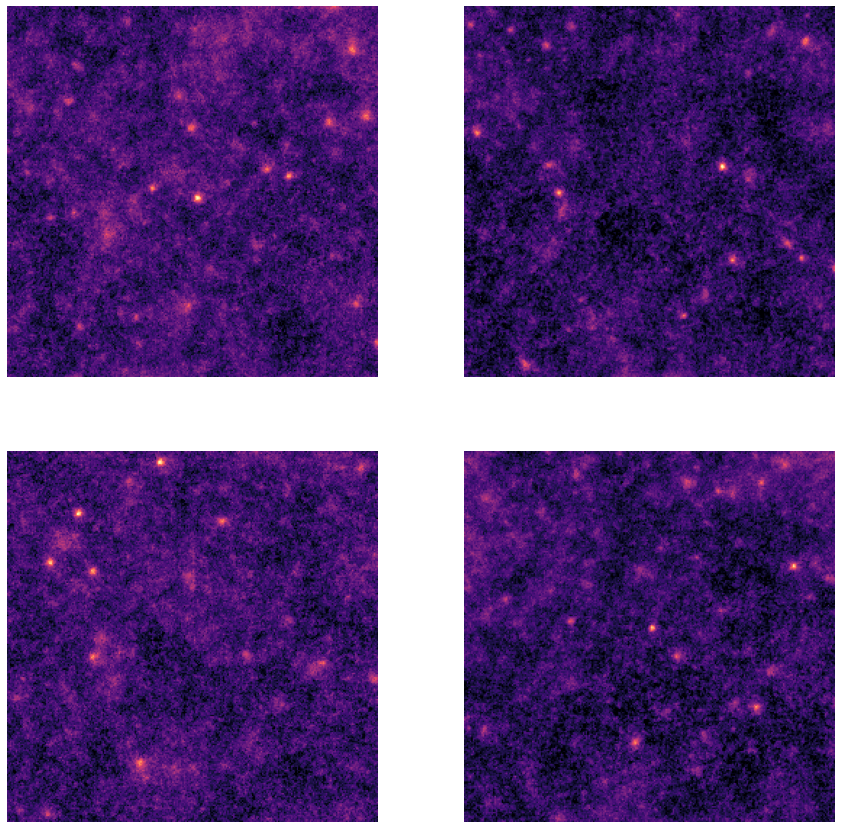

In [34]:
figure(figsize=[15,15])
for i in range(2):
    for j in range(2):
        subplot(2, 2, i*2+j+1)
        imshow(((s[-1,i*2+j].reshape((320,320))))[:,::-1][160-128:160+128,
                                                     160-128:160+128], 
               cmap='magma',origin='lower', vmin=-0.05, vmax=0.2)
        axis('off')

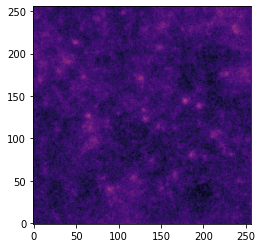

In [36]:
imshow(((s[-1].mean(axis=0).reshape((320,320))))[:,::-1][160-128:160+128,
                                             160-128:160+128], 
       cmap='magma',origin='lower', vmin=-0.05, vmax=0.2)

In [39]:
vmax=s[-1].mean(axis=0).reshape((320,320))[160-128:160+128,
                                             160-128:160+128][:,::-1].max()

Text(0.5, 1.0, 'std')

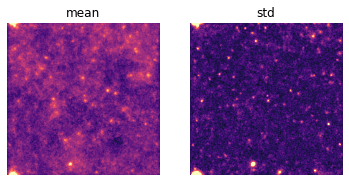

In [40]:
subplot(121)
imshow(s[-1].mean(axis=0).reshape((320,320))[:,::-1],cmap='magma',
       origin='lower',vmax=vmax)
axis('off')
title('mean')
subplot(122)
imshow(s[-1].std(axis=0).reshape((320,320))[:,::-1],cmap='magma',
       origin='lower',vmax=vmax)
axis('off')
title('std')